<a href="https://colab.research.google.com/github/Srivardini/Artificial_star/blob/main/Code_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Artificial star**

# **Import**

In [2]:
import os

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from photutils.aperture import EllipticalAperture

In [4]:
# Use custom style for larger fonts and figures
plt.style.use('ggplot')

In [5]:
# Set up the random number generator, allowing a seed to be set from the environment
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)
    
# This is the generator to use for any image component which changes in each image, e.g. read noise
# or Poisson error
noise_rng = np.random.default_rng(seed)

# Import function: Show image

In [8]:
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


def image_snippet(image, center, width=50, axis=None, fig=None,
                  is_mask=False, pad_black=False, **kwargs):
    """
    Display a subsection of an image about a center.

    Parameters
    ----------

    image : numpy array
        The full image from which a section is to be taken.

    center : list-like
        The location of the center of the cutout.

    width : int, optional
        Width of the cutout, in pixels.

    axis : matplotlib.Axes instance, optional
        Axis on which the image should be displayed.

    fig : matplotlib.Figure, optional
        Figure on which the image should be displayed.

    is_mask : bool, optional
        Set to ``True`` if the image is a mask, i.e. all values are
        either zero or one.

    pad_black : bool, optional
        If ``True``, pad edges of the image with zeros to fill out width
        if the slice is near the edge.
    """
    if pad_black:
        sub_image = Cutout2D(image, center, width, mode='partial', fill_value=0)
    else:
        # Return a smaller subimage if extent goes out side image
        sub_image = Cutout2D(image, center, width, mode='trim')
    show_image(sub_image.data, cmap='gray', ax=axis, fig=fig,
               show_colorbar=False, show_ticks=False, is_mask=is_mask,
               **kwargs)


def _mid(sl):
    return (sl.start + sl.stop) // 2


def display_cosmic_rays(cosmic_rays, images, titles=None,
                        only_display_rays=None):
    """
    Display cutouts of the region around each cosmic ray and the other images
    passed in.

    Parameters
    ----------

    cosmic_rays : photutils.segmentation.SegmentationImage
        The segmented cosmic ray image returned by ``photuils.detect_source``.

    images : list of images
        The list of images to be displayed. Each image becomes a column in
        the generated plot. The first image must be the cosmic ray mask.

    titles : list of str
        Titles to be put above the first row of images.

    only_display_rays : list of int, optional
        The number of the cosmic ray(s) to display. The default value,
        ``None``, means display them all. The number of the cosmic ray is
        its index in ``cosmic_rays``, which is also the number displayed
        on the mask.
    """
    # Check whether the first image is actually a mask.

    if not ((images[0] == 0) | (images[0] == 1)).all():
        raise ValueError('The first image must be a mask with '
                         'values of zero or one')

    if only_display_rays is None:
        n_rows = len(cosmic_rays.slices)
    else:
        n_rows = len(only_display_rays)

    n_columns = len(images)

    width = 12

    # The height below is *CRITICAL*. If the aspect ratio of the figure as
    # a whole does not allow for square plots then one ends up with a bunch
    # of whitespace. The plots here are square by design.
    height = width / n_columns * n_rows
    fig, axes = plt.subplots(n_rows, n_columns, sharex=False, sharey='row',
                             figsize=(width, height))

    # Generate empty titles if none were provided.
    if titles is None:
        titles = [''] * n_columns

    display_row = 0

    for row, s in enumerate(cosmic_rays.slices):
        if only_display_rays is not None:
            if row not in only_display_rays:
                # We are not supposed to display this one, so skip it.
                continue

        x = _mid(s[1])
        y = _mid(s[0])

        for column, plot_info in enumerate(zip(images, titles)):
            image = plot_info[0]
            title = plot_info[1]
            is_mask = column == 0
            ax = axes[display_row, column]
            image_snippet(image, (x, y), width=80, axis=ax, fig=fig,
                          is_mask=is_mask)
            if is_mask:
                ax.annotate('Cosmic ray {}'.format(row), (0.1, 0.9),
                            xycoords='axes fraction',
                            color='cyan', fontsize=20)

            if display_row == 0:
                # Only set the title if it isn't empty.
                if title:
                    ax.set_title(title)

        display_row = display_row + 1

    # This choice results in the images close to each other but with
    # a small gap.
    plt.subplots_adjust(wspace=0.1, hspace=0.05)

# Image

**1.1 A blank image**

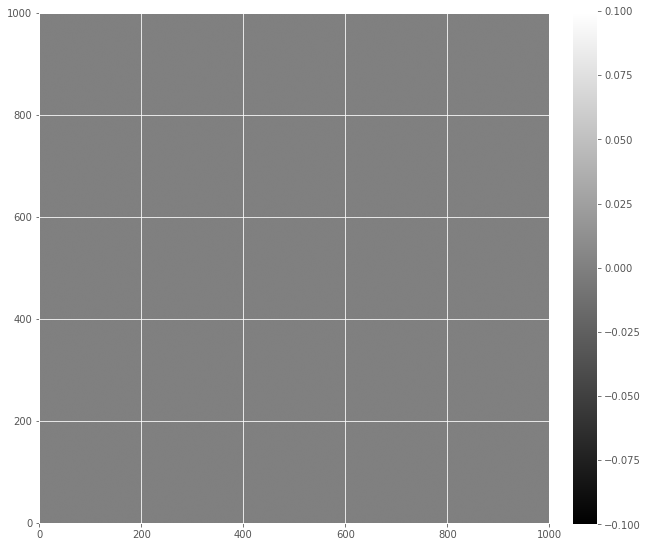

In [9]:
synthetic_image = np.zeros([1000, 1000])
show_image(synthetic_image, cmap='gray')

**1.2 Add some noise** 

In [10]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = noise_rng.normal(scale=amount/gain, size=shape)
    
    return noise

<Figure size 432x288 with 0 Axes>

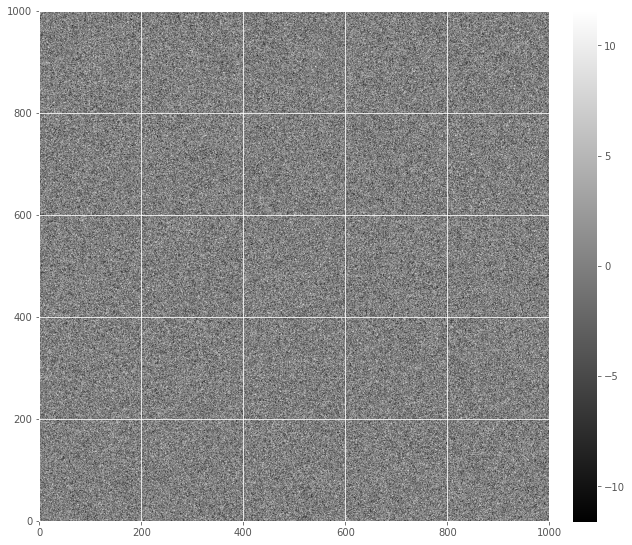

In [11]:
plt.figure()
noise_im = synthetic_image + read_noise(synthetic_image, 5)
show_image(noise_im, cmap='gray')

**1.3 Read noise**

In [12]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = noise_rng.normal(scale=amount/gain, size=shape)
    
    return noise

<Figure size 432x288 with 0 Axes>

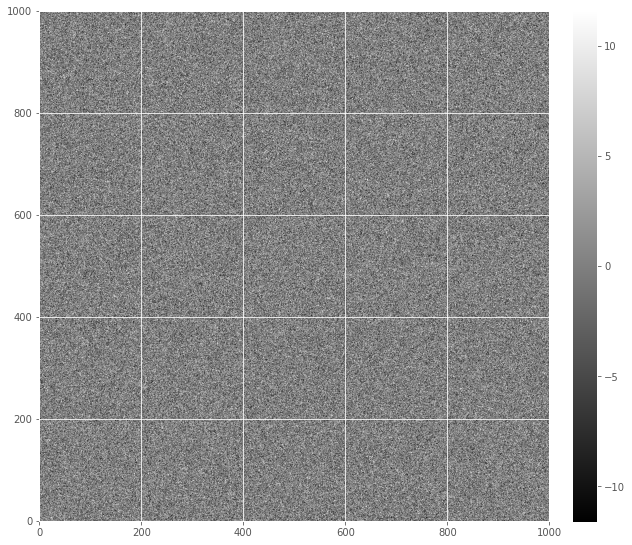

In [13]:
plt.figure()
noise_im = synthetic_image + read_noise(synthetic_image, 5)
show_image(noise_im, cmap='gray')

**1.4 Bias**

In [14]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value
    
    # If we want a more realistic bias we need to do a little more work. 
    if realistic:
        shape = image.shape
        number_of_colums = 5
        
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])
        
        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern
            
    return bias_im
        

Text(0.5, 1.0, 'Bias alone, bad columns included')

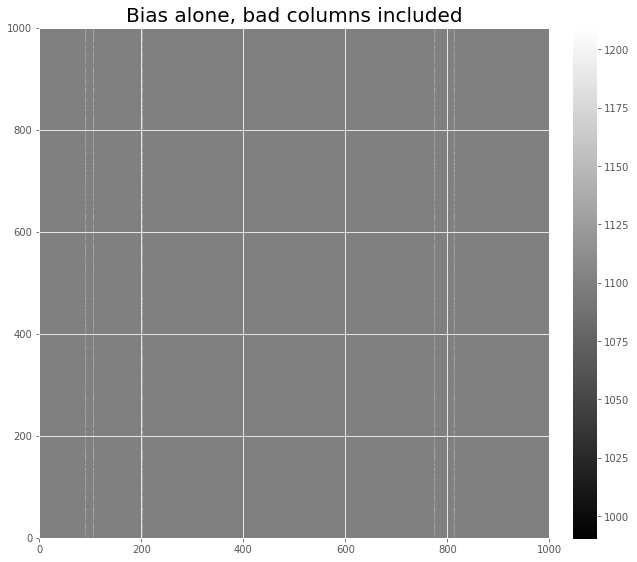

In [15]:
bias_only = bias(synthetic_image, 1100, realistic=True)
show_image(bias_only, cmap='gray', figsize=(10, 10))
plt.title('Bias alone, bad columns included', fontsize='20')

Text(0.5, 1.0, 'Realistic bias frame (includes read noise)')

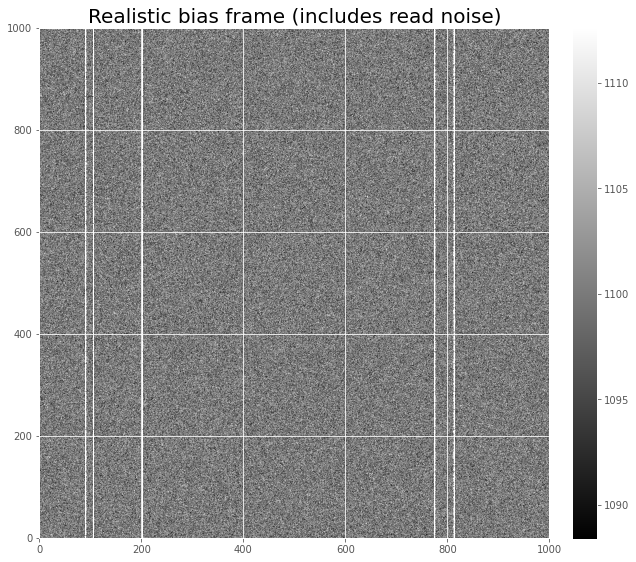

In [16]:
bias_noise_im = noise_im + bias_only
show_image(bias_noise_im, cmap='gray', figsize=(10, 10))
plt.title('Realistic bias frame (includes read noise)', fontsize='20')

**1.5 Dark current**

In [17]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = noise_rng.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain
    return dark_im

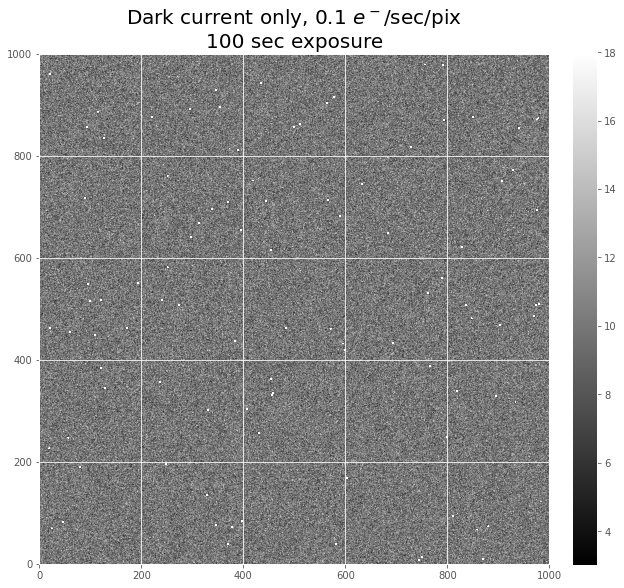

In [18]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
show_image(dark_only, cmap='gray')
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');

Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

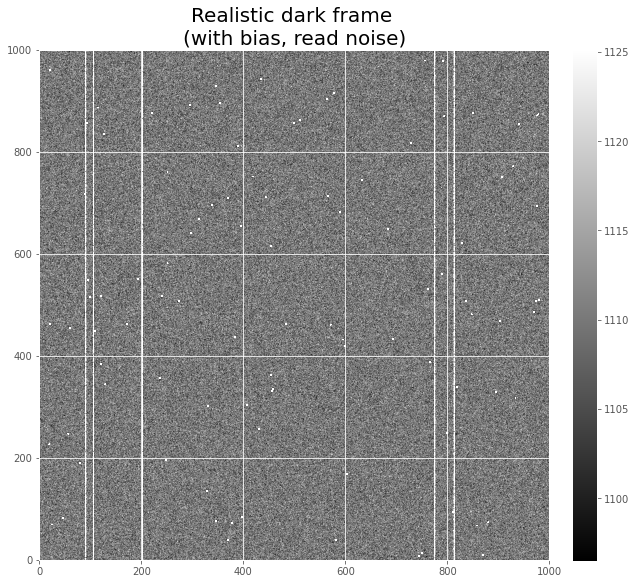

In [19]:
dark_bias_noise_im = bias_noise_im + dark_only
show_image(dark_bias_noise_im, cmap='gray')
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')

**1.6 Sky background**

In [21]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = noise_rng.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im

Text(0.5, 1.0, 'Sky background only, 20 counts input')

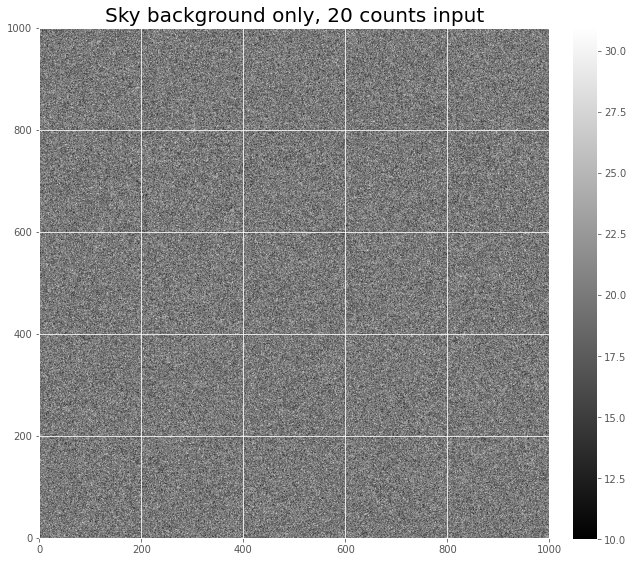

In [22]:
sky_level = 20
sky_only = sky_background(synthetic_image, sky_level)
show_image(sky_only, cmap='gray')
plt.title('Sky background only, {} counts input'.format(sky_level), fontsize=20)

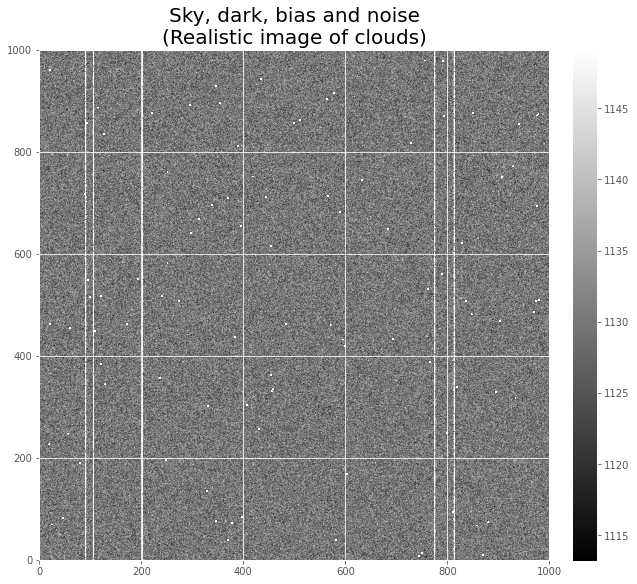

In [23]:
sky_dark_bias_noise_im = dark_bias_noise_im + sky_only
show_image(sky_dark_bias_noise_im, cmap='gray')
plt.title('Sky, dark, bias and noise\n(Realistic image of clouds)', fontsize=20);

In [24]:
from ipywidgets import interactive, interact

# @interact(bias_level=(1000,1200,10), dark=(0.01,1,0.01), sky_counts=(0, 300, 10),
#           gain=(0.5, 3.0, 0.1), read=(0, 50, 2.0),
#           exposure=(0, 300, 10))
def complete_image(bias_level=1100, read=10.0, gain=1, dark=0.1, 
                   exposure=30, hot_pixels=True, sky_counts=200):
    synthetic_image = np.zeros([500, 500])
    show_image(synthetic_image + 
               read_noise(synthetic_image, read) +
               bias(synthetic_image, bias_level, realistic=True) + 
               dark_current(synthetic_image, dark, exposure, hot_pixels=hot_pixels) +
               sky_background(synthetic_image, sky_counts),
               cmap='gray',
               figsize=None)
    
i = interactive(complete_image, bias_level=(1000,1200,10), dark=(0.0,1,0.1), sky_counts=(0, 300, 50),
          gain=(0.5, 3.0, 0.25), read=(0, 50, 5.0),
          exposure=(0, 300, 30))

for kid in i.children:
    try:
        kid.continuous_update = False
    except KeyError:
        pass
i

interactive(children=(IntSlider(value=1100, continuous_update=False, description='bias_level', max=1200, min=1…

In [25]:
def stars(image, number, max_counts=10000, gain=1):
    """
    Add some stars to the image.
    """
    from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image
    # Most of the code below is a direct copy/paste from
    # https://photutils.readthedocs.io/en/stable/_modules/photutils/datasets/make.html#make_100gaussians_image
    
    flux_range = [max_counts/10, max_counts]
    
    y_max, x_max = image.shape
    xmean_range = [0.1 * x_max, 0.9 * x_max]
    ymean_range = [0.1 * y_max, 0.9 * y_max]
    xstddev_range = [4, 4]
    ystddev_range = [4, 4]
    params = dict([('amplitude', flux_range),
                  ('x_mean', xmean_range),
                  ('y_mean', ymean_range),
                  ('x_stddev', xstddev_range),
                  ('y_stddev', ystddev_range),
                  ('theta', [0, 2*np.pi])])

    sources = make_random_gaussians_table(number, params,
                                          seed=12345)
    
    star_im = make_gaussian_sources_image(image.shape, sources)
    
    return star_im

Text(0.5, 1.0, 'Stars only')

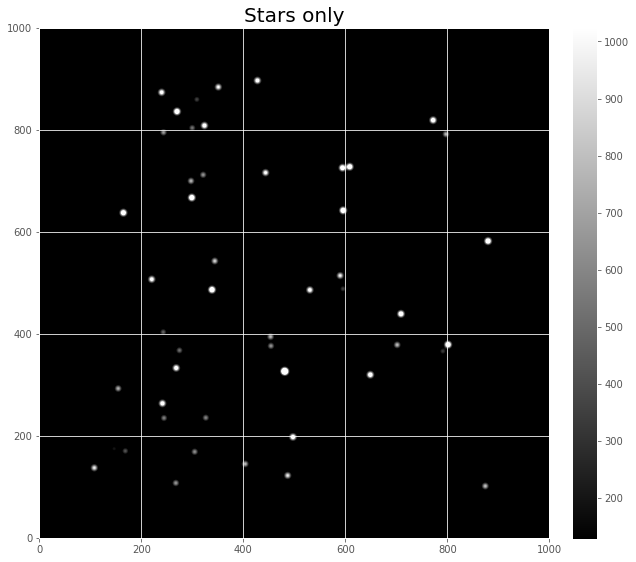

In [26]:
stars_only = stars(synthetic_image, 50, max_counts=2000)
show_image(stars_only, cmap='gray', percu=99.9)
plt.title('Stars only'.format(stars_only), fontsize=20)

In [27]:
stars_with_background = sky_dark_bias_noise_im + stars_only

Text(0.5, 1.0, 'Stars with noise, bias, dark, sky')

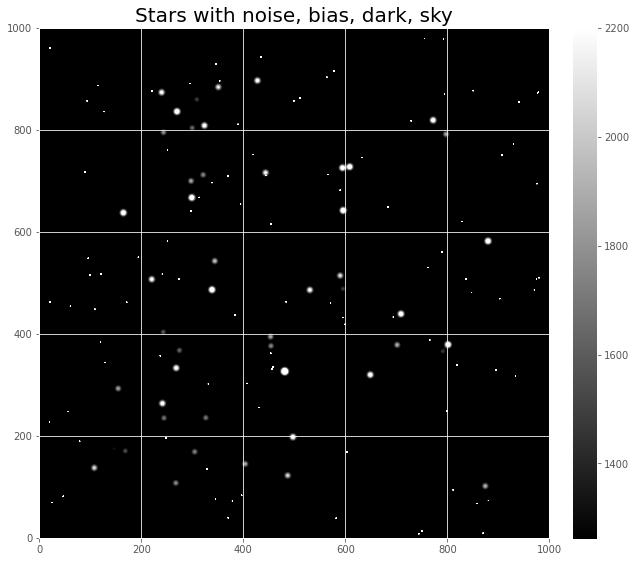

In [28]:
show_image(stars_with_background, cmap='gray', percu=99.9)
plt.title('Stars with noise, bias, dark, sky'.format(stars_with_background), fontsize=20)